<a href="https://colab.research.google.com/github/mohammadRahimi1993/BigData/blob/main/LogisticRegression_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Connecting Drive to Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2.Install package**

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install handyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 53.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=20740a0fcec0c46a038fcf72318bcf4299239cef1d2a2b42276d5eb4c144b53b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# **3.Setting up PySpark in Colab**

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [5]:
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

# **4.Load data**

In [7]:
data=spark.read.csv('/content/drive/MyDrive/DataSet/DataSartipi.csv',inferSchema=True, header=True)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|         Yes|          Yes|    Fiber optic|            No|          No|             Yes|         No|        Yes|    

# **5.Preprocessing**

# **5.1 Delete Columns of PaperlessBilling**

In [9]:
data_Pro_1=data.drop('PaperlessBilling','Dependents')
print("Size of data is:" , data_Pro_1.count())
print("the data is:")
data_Pro_1.show(5)

Size of data is: 229990
the data is:
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|  54.0|         Yes|          Yes|    Fiber optic|            No|          No|             Yes|         No|        Yes|            Yes|Month-to-month|Credit card (auto...|         9

# **5.2 Delete null fields of customerID and Lable**

In [10]:
#Delete null fields in customerID and Lable
data_Pro_2 = data_Pro_1.filter(data_Pro_1.customerID.isNotNull())
data_Pro_2 = data_Pro_2.filter(data_Pro_2.Label.isNotNull())
print("the data is delete with null customerID.")
print("Size of data is: ", data_Pro_2.count())
data_Pro_2.show(5)

the data is delete with null customerID.
Size of data is:  229589
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|  54.0|         Yes|          Yes|    Fiber optic|            No|          No|             Yes|         No|        Yes|            Yes|Month-to-month|Cr

# Check null value

In [11]:
# Creating a dataframe to check null value counts
from pyspark.sql.functions import col,isnan, when, count
null_df = data_Pro_2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in data_Pro_2.columns])

# Displaying the null value counts dataframe
null_df.show()

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|         0|   123|          130|    106|   109|         133|          132|            119|           115|         128|             129|        138|        120|            114|     110|          133|           131|         122|    0|
+----------+------+-------------+-------+------+------------+---

# **5.3 Replace missing values with means**

In [12]:
#Fill missing values of TotalCharges, MonthlyCharges and tenure to mean
print("*********************************************")
TotalCharges_mean = data_Pro_2.select(["TotalCharges"]).toPandas().mean()[0]
print("Avrage of TotalCharges columns is:",TotalCharges_mean)
data_Pro_2 = data_Pro_2.na.fill( TotalCharges_mean,subset='TotalCharges')
print("*********************************************")
MonthlyCharges_mean = data_Pro_2.select(["MonthlyCharges"]).toPandas().mean()[0]
print("Avrage of MonthlyCharges_mean columns is:",MonthlyCharges_mean)
data_Pro_2 = data_Pro_2.na.fill( MonthlyCharges_mean,subset='MonthlyCharges')
print("*********************************************")
tenure_mean = data_Pro_2.select(["tenure"]).toPandas().mean()[0]
print("Avrage of MonthlyCharges_mean columns is:",tenure_mean)
data_Pro_2 = data_Pro_2.na.fill(tenure_mean,subset='tenure')
print("the data next fill avg:\n")
data_Pro_2.show(5)

*********************************************
Avrage of TotalCharges columns is: 3701.7594560437465
*********************************************
Avrage of MonthlyCharges_mean columns is: 126.42422251567098
*********************************************
Avrage of MonthlyCharges_mean columns is: 49.436085933414674
the data next fill avg:

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+-------

# Check null value

In [13]:
# Creating a dataframe to check null value counts
from pyspark.sql.functions import col,isnan, when, count
null_df = data_Pro_2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in data_Pro_2.columns])

# Displaying the null value counts dataframe
null_df.show()

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|         0|   123|          130|    106|     0|         133|          132|            119|           115|         128|             129|        138|        120|            114|     110|          133|             0|           0|    0|
+----------+------+-------------+-------+------+------------+---

# **6.Data Expolaration Analysis**

# **6.1 schema information**

In [12]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



# **6.2 handyspark dataframe**

In [14]:
# PaperlessBilling and Dependents
from handyspark import *
indexer= StringIndexer(inputCol="Label", outputCol="Label_index").fit(data)
data_Pro_22 = indexer.transform(data)
indexer= StringIndexer(inputCol="Contract", outputCol="Contract_index").fit(data_Pro_2)
data_Pro_22 = indexer.transform(data_Pro_22)
hdf = data_Pro_22.toHandy()
hdf.show(3)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----------+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|Label_index|Contract_index|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----------+--------------+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|         Yes|          Yes|    Fibe

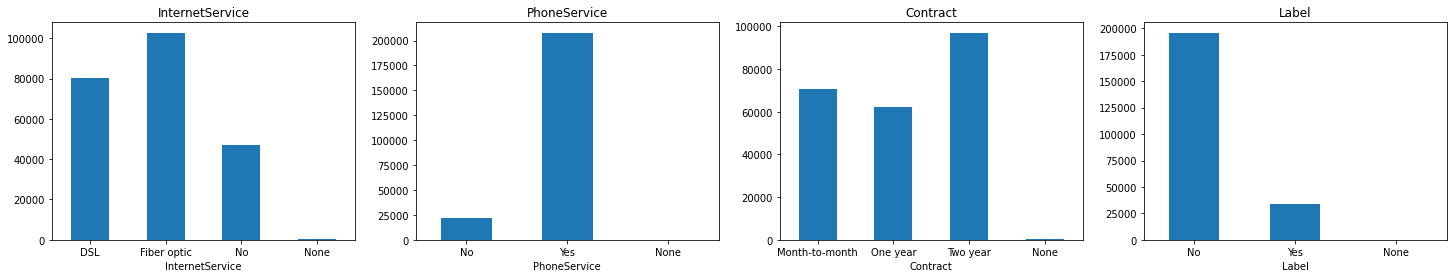

In [14]:
#hdf.cols['PhoneService'].value_counts(dropna=False)
#hdf.cols['Contract'].boxplot(ax=axs[2])
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(25, 4))
#hdf.cols[['TotalCharges', 'Label_index']].scatterplot(ax=axs[2])
hdf.cols['InternetService'].hist(ax=axs[0])
hdf.cols['PhoneService'].hist(ax=axs[1])
hdf.cols['Contract'].hist(ax=axs[2])
hdf.cols['Label'].hist(ax=axs[3])

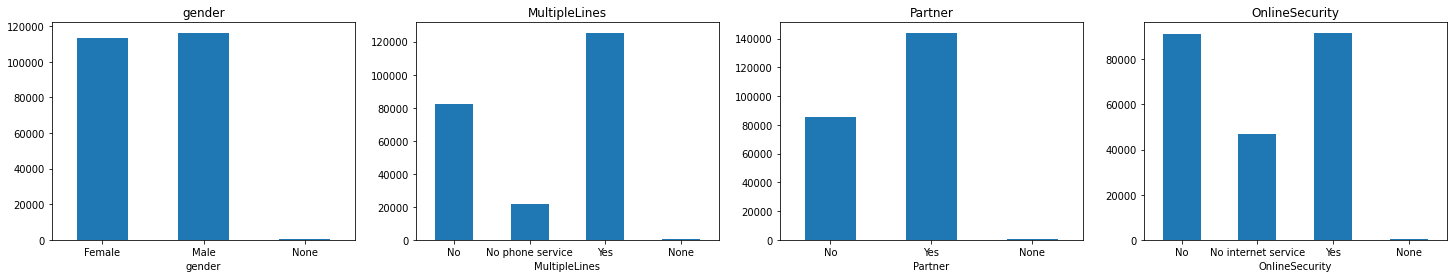

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4))
#hdf.cols[['TotalCharges', 'Label_index']].scatterplot(ax=axs[2])
hdf.cols['gender'].hist(ax=axs[0])
hdf.cols['MultipleLines'].hist(ax=axs[1])
hdf.cols['Partner'].hist(ax=axs[2])
hdf.cols['OnlineSecurity'].hist(ax=axs[3])

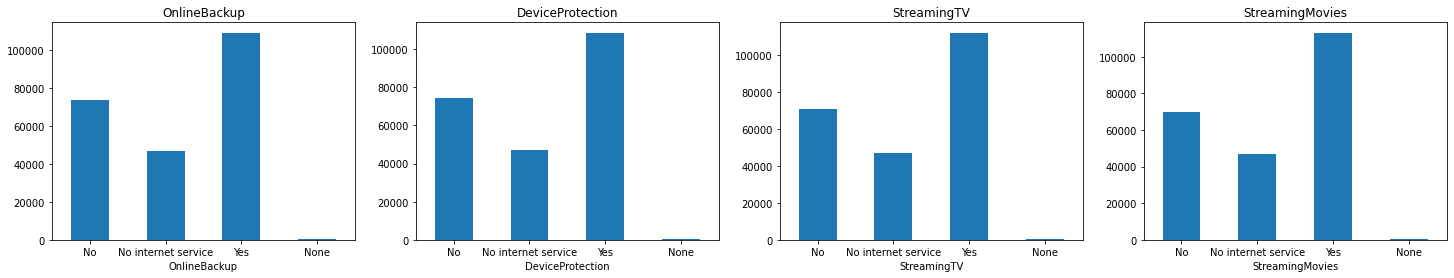

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4))
#hdf.cols[['TotalCharges', 'Label_index']].scatterplot(ax=axs[2])
hdf.cols['OnlineBackup'].hist(ax=axs[0])
hdf.cols['DeviceProtection'].hist(ax=axs[1])
hdf.cols['StreamingTV'].hist(ax=axs[2])
hdf.cols['StreamingMovies'].hist(ax=axs[3])

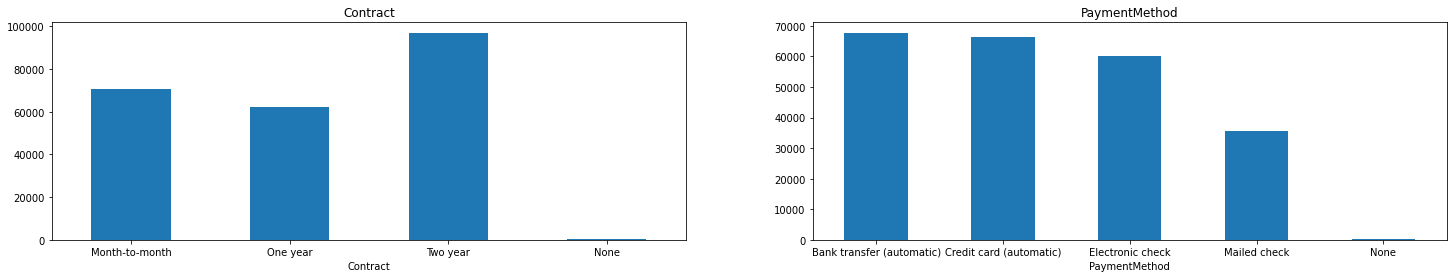

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(25, 4))
hdf.cols['Contract'].hist(ax=axs[0])
hdf.cols['PaymentMethod'].hist(ax=axs[1])

(<Figure size 576x432 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd38d850690>])

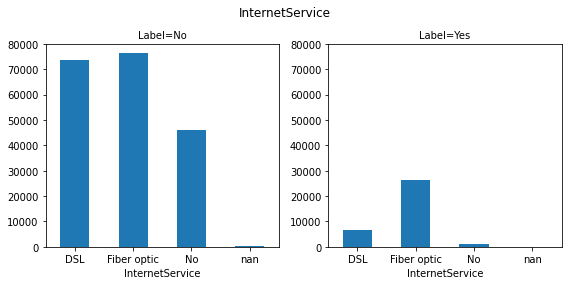

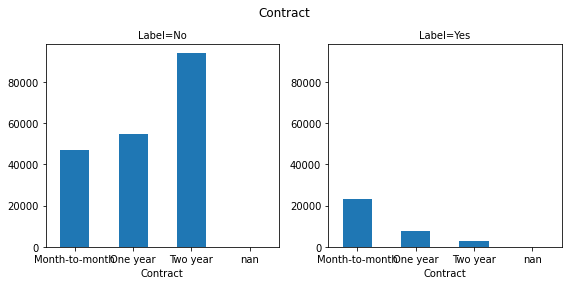

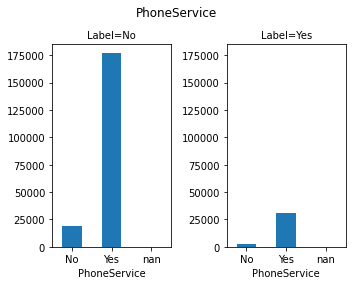

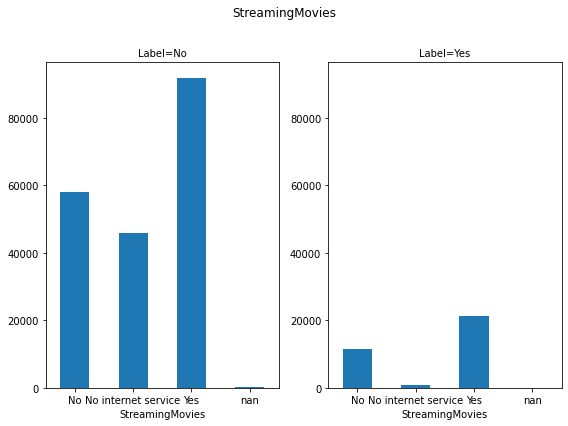

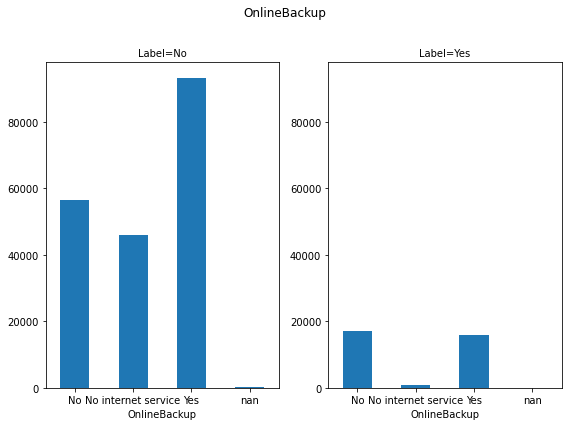

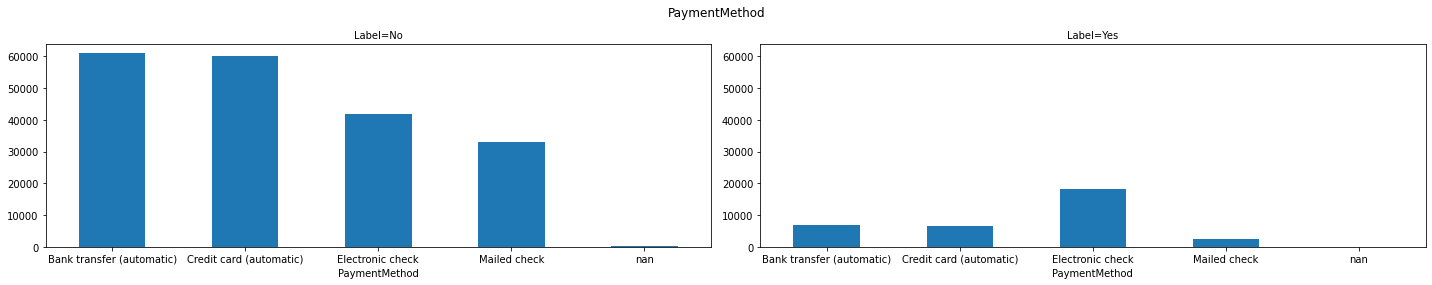

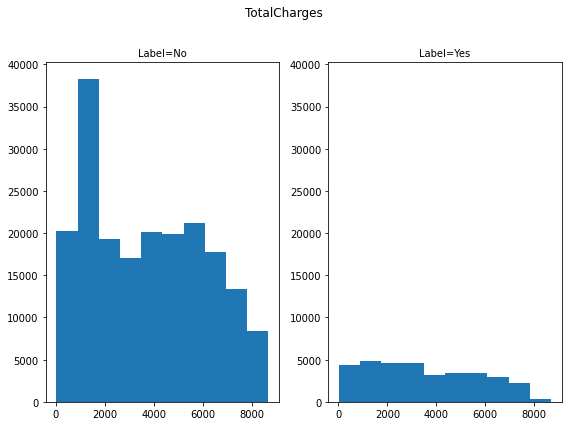

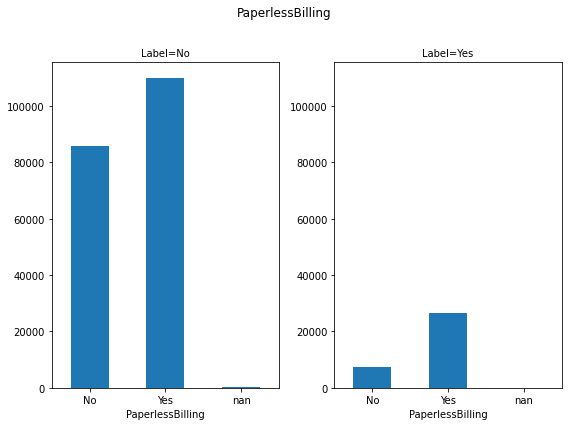

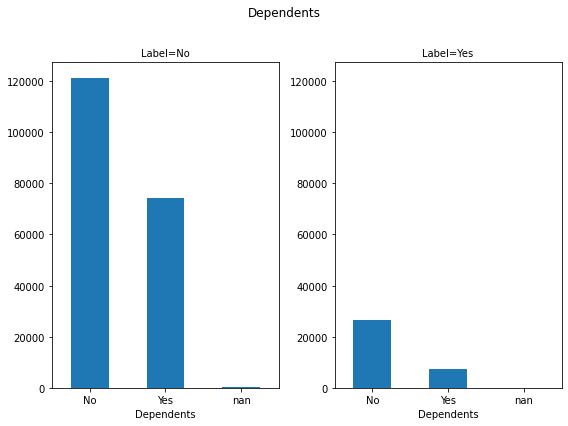

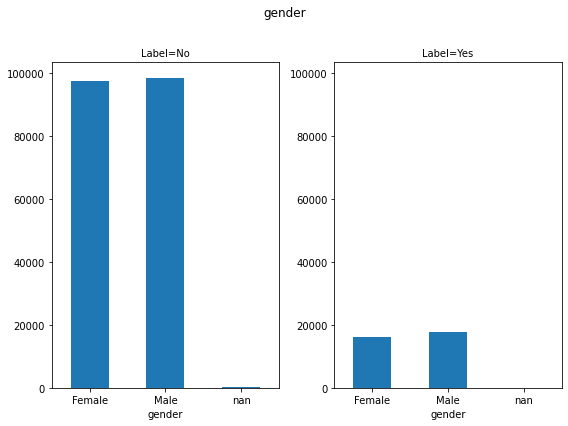

In [15]:
# hdf.stratify(['Label', Bucket('TotalCharges', 2)]).cols['PhoneService'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['InternetService'].hist(figsize=(8, 4))
hdf.stratify(['Label']).cols['Contract'].hist(figsize=(8, 4))
hdf.stratify(['Label']).cols['PhoneService'].hist(figsize=(5, 4))
hdf.stratify(['Label']).cols['StreamingMovies'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['OnlineBackup'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['PaymentMethod'].hist(figsize=(20, 4))
hdf.stratify(['Label']).cols['TotalCharges'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['PaperlessBilling'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['Dependents'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['gender'].hist(figsize=(8, 6))

# **7.Implementing logistic regression**

In [19]:
hasher = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
hasher_org = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
featurized = hasher.transform(data_Pro_2)
featurized_org = hasher_org.transform(data)
featurized.show(5, truncate=False)
featurized_org.show(5, truncate=False)

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+-------------------------+--------------+------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaymentMethod            |MonthlyCharges|TotalCharges|Label|features                                                                                                                                                                                                  |
+----------+------+-------------+-------+------+------------+-------------+---------------

# **7.1.Featurizing**

In [20]:
featurized=featurized["Label","features","customerID"]
featurized_org=featurized_org["Label","features","customerID"]
featurized.show(5, truncate=False)
featurized_org.show(5, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Label|features                                                                                                                                                                                                  |customerID|
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|No   |(262144,[20762,35396,40671,74746,119757,139220,143274,144894,180881,190858,190991,196278,203276,218283,222701,241506,246667],[99.05,1.0,1.0,1.0,1.0,1.0,54.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5295.7]) |5331-RGMTT|
|No   |(262144,[7831,20762,35396,62450,72938,74746,139220,143274,144894,190858,190991,196278,203276,205898,22270

In [21]:
def f(x): 
    if(x == 'Yes'):
       return 1

    else:
       return 0

featurized=featurized.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
featurized=featurized.withColumnRenamed("Label","label")
featurized_org=featurized_org.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
featurized_org=featurized_org.withColumnRenamed("Label","label")
featurized.show(5)
featurized_org.show(5)

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[20762,35...|5331-RGMTT|
|    0|(262144,[7831,207...|5161-XEUVX|
|    0|(262144,[7831,205...|0336-PIKEI|
|    0|(262144,[7831,205...|3345-PBBFH|
|    0|(262144,[20762,35...|5067-XJQFU|
+-----+--------------------+----------+
only showing top 5 rows

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[20762,35...|5331-RGMTT|
|    0|(262144,[7831,207...|5161-XEUVX|
|    0|(262144,[7831,205...|0336-PIKEI|
|    0|(262144,[7831,205...|3345-PBBFH|
|    0|(262144,[20762,35...|5067-XJQFU|
+-----+--------------------+----------+
only showing top 5 rows



# **7.2.Spliting data into training and test sets**

In [22]:
train, test = featurized.randomSplit(weights=[0.8,0.2], seed=200)
train_org, test_org = featurized_org.randomSplit(weights=[0.8,0.2], seed=200)
train.show(5)
test.show(5)

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
+-----+--------------------+----------+
only showing top 5 rows

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|9286-BHDQG|
+-----+--------------------+----------+
only showing top 5 rows



# **7.3. Creating an instance of logistic regression**

In [23]:
lr=LogisticRegression(maxIter=1000,regParam=0.0000001,) # as an estimator
lr.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

# **7.4. Learning the model**

In [24]:
model1=lr.fit(train)
model_org=lr.fit(train_org)

In [25]:
model1.coefficients
model_org.coefficients

SparseVector(262144, {4236: 0.2373, 7831: -0.0486, 20545: 0.3003, 20762: 0.0, 35396: 0.3086, 40671: 0.4023, 53807: -0.132, 57644: -0.091, 59103: -0.1197, 62450: 0.1207, 72938: -0.7537, 74746: -0.1506, 77335: -0.2565, 97174: -0.1089, 97284: -0.1515, 100321: -0.0989, 109041: -0.0763, 112867: -0.3043, 119757: 0.3545, 124394: 0.5332, 139220: 0.2195, 139721: -0.0417, 143274: -0.0001, 144208: -0.2111, 144894: 0.2098, 148734: -0.1497, 153197: -0.1003, 163470: 0.2898, 180881: -0.0953, 190858: -0.0773, 190991: 0.3608, 196278: 0.3942, 203276: 0.6617, 205898: -0.243, 213513: -0.1227, 218283: 0.7134, 222701: 0.0999, 240448: 0.0804, 241506: 0.9652, 246667: -0.0003, 253914: 0.2064, 256762: 0.0572, 257928: 0.3842})

# **7.4 Test**

In [26]:
predictions=model1.transform(test)
predictions_org=model_org.transform(test_org)
predictions.show(5)
predictions_org.show(5)

+-----+--------------------+----------+--------------------+--------------------+----------+
|label|            features|customerID|       rawPrediction|         probability|prediction|
+-----+--------------------+----------+--------------------+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|[3.57095436279797...|[0.97264059692935...|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[3.57095436279797...|[0.97264059692935...|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[3.57095436279797...|[0.97264059692935...|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[3.57095436279797...|[0.97264059692935...|       0.0|
|    0|(262144,[4236,783...|9286-BHDQG|[4.06093174412789...|[0.98305898875512...|       0.0|
+-----+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows

+-----+--------------------+----------+--------------------+--------------------+----------+
|label|            features|customerID|      

# **7.5 Comparing labels with predictions**

In [29]:
predictions.groupBy('label', 'prediction').count().show()
predictions_org.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()

# Calculate the elements of the confusion matrix
TN_org = predictions_org.filter('prediction = 0 AND label = prediction').count()
TP_org = predictions_org.filter('prediction = 1 AND label = prediction').count()
FN_org = predictions_org.filter('prediction = 0 AND label = 1').count()
FP_org = predictions_org.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
accuracy_org = (TN_org + TP_org) / (TN_org + TP_org + FN_org + FP_org)

print("Accuracy of preprocess data is:",accuracy)
print("Accuracy of orginal  data is:",accuracy_org)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5050|
|    0|       0.0|37988|
|    1|       1.0| 1777|
|    0|       1.0| 1114|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5009|
|    0|       0.0|38015|
|    1|       1.0| 1838|
|    0|       1.0| 1162|
+-----+----------+-----+

Accuracy of preprocess data is: 0.8657928541879858
Accuracy of orginal  data is: 0.8659177820267686
